## <span color = 'red'> Peaks and Holes Forming Analysis 

In [14]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter
from scipy.stats import linregress
import cv2
from preprocessing import preprocessing_v2 as pp
from pathlib import Path
from utils.file_util_exec import path_to_str
from utils import graph_utils as gu
from scipy.ndimage import gaussian_filter
plt.rcParams['font.size'] = 20
plt.rcParams['image.origin'] = 'lower'


In [2]:
# file paths
DATA_PATH = Path(r'D:\Gel_Sheet_Data\\')
movie_list = ['130721_CCA60', 'cca120_am200', 'control_1_050721']
movie =Path(movie_list[0])
MOVIE_PATH = DATA_PATH /  movie 
GRAPH_PATH = Path('C:/Users/amityu/Gel_Sheet_Graph/')
ex_data = pp.get_ex_data(path_to_str(MOVIE_PATH) )
OUTPUT_PATH = GRAPH_PATH /Path('coarsening')


In [10]:


def load_blob_data(blob_type, movie_path, ex_data):
    if blob_type == 'surface':
        image_sequence = pp.get_merged_spike(path_to_str(movie_path), ex_data)
        blob_file_path = movie_path / Path('np/surface_blobs.csv')
    elif blob_type == 'membrane':
        gel = np.load(movie_path / Path('np/gel_norm.npy'))
        membrane = np.load(movie_path / Path('np/membrane.npy'))
        image_sequence = au.get_surface_intensity(gel, membrane)
        blob_file_path = movie_path / Path('np/membrane_blobs.csv')
    else:
        raise ValueError("Invalid blob type. Choose 'surface' or 'membrane'.")

    df = pd.read_csv(blob_file_path)
    return df, image_sequence


# Setting the blob type flag to 'surface' or 'membrane'
blob_type = 'membrane'
df, image_sequence = load_blob_data(blob_type, MOVIE_PATH, ex_data)

# Display the first few rows
print(df.head())

   Unnamed: 0      y      x  sigma    radius    height  intensity  frame
0           0  413.0  474.0    1.0  1.414214  0.532388   0.532388      0
1           1   31.0  347.0    1.0  1.414214  0.553792   0.553792      0
2           2  422.0    0.0    1.0  1.414214  0.638768   0.638768      0
3           3   52.0  382.0    1.0  1.414214  0.544542   0.544542      0
4           4  297.0  285.0    1.0  1.414214  0.572720   0.572720      0


Total number of frames: 62
Total number of blobs detected: 385327


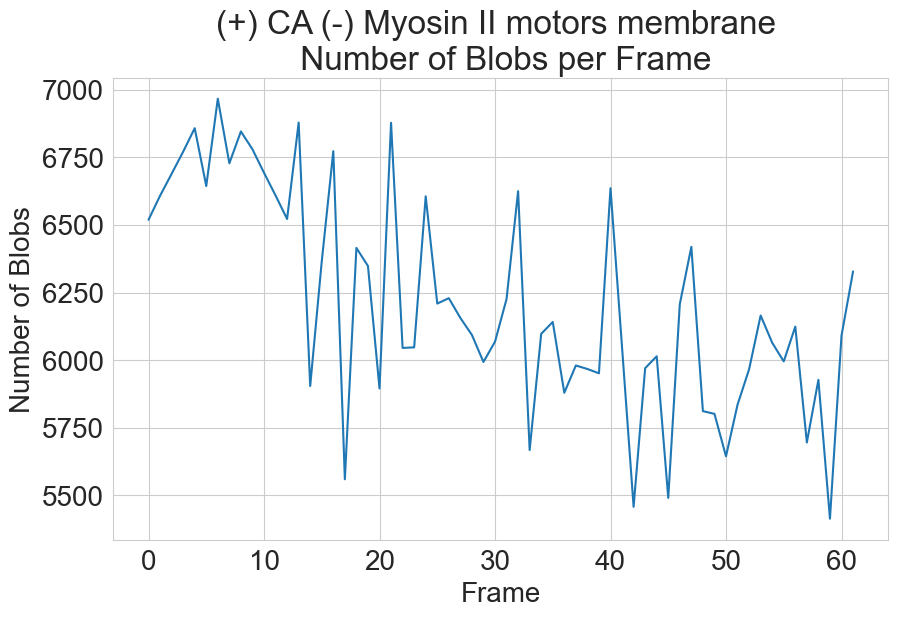

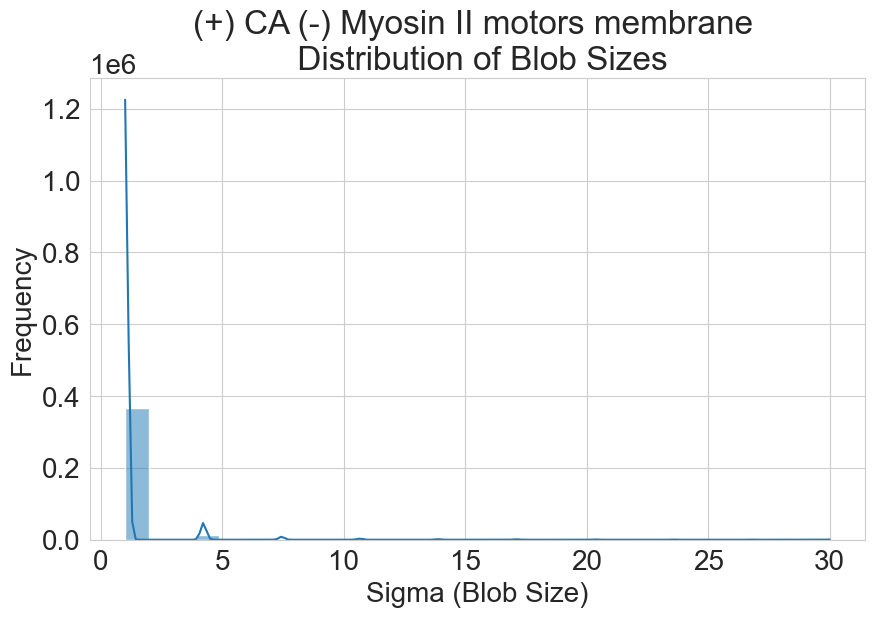

In [105]:
# blobs per frame
# Total number of frames
num_frames = df['frame'].nunique()
print(f"Total number of frames: {num_frames}")

# Total number of blobs
total_blobs = len(df)
print(f"Total number of blobs detected: {total_blobs}")

# Blobs per frame
blobs_per_frame = df['frame'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x=blobs_per_frame.index, y=blobs_per_frame.values)
plt.xlabel('Frame')
plt.ylabel('Number of Blobs')
plt.title(f'{ex_data["name"]} {blob_type} \n Number of Blobs per Frame')
plt.savefig(OUTPUT_PATH / Path(f'{movie}_{blob_type}_n_blob.png'))

plt.show()

# Distribution of blob sizes (sigma)
plt.figure(figsize=(10, 6))
sns.histplot(df['sigma'], bins=30, kde=True)
plt.xlabel('Sigma (Blob Size)')
plt.ylabel('Frequency')
plt.title(f'{ex_data["name"]} {blob_type} \n Distribution of Blob Sizes')
plt.savefig(OUTPUT_PATH / Path(f'{movie}_{blob_type}_blob_distribution.png'))

plt.show()


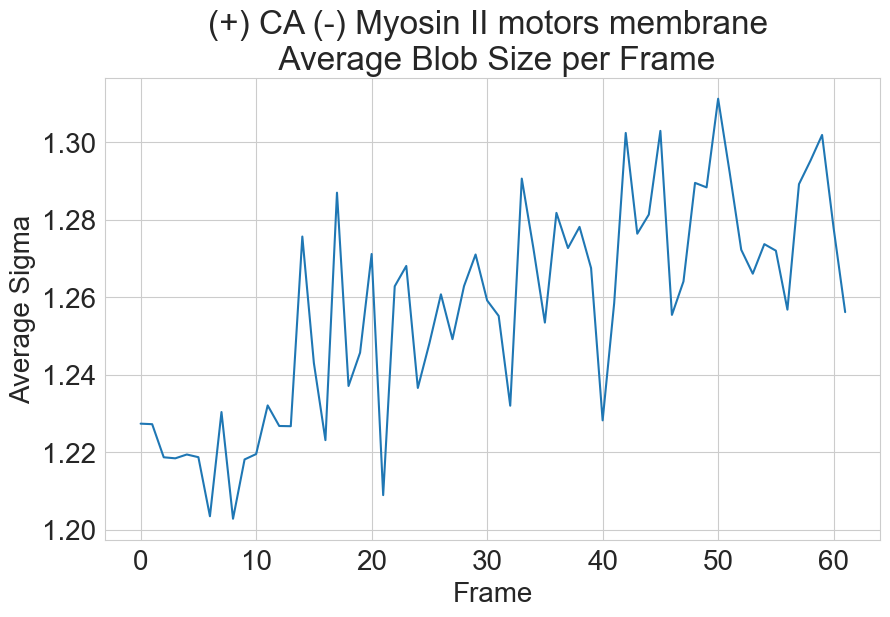

Coarsening exponent (slope): 0.019


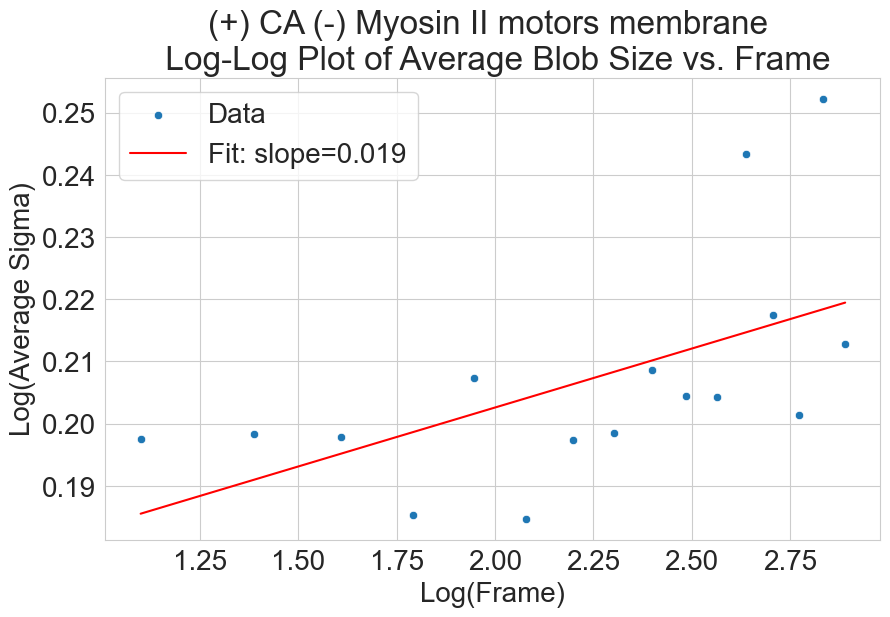

In [106]:
# Average blob size per frame
avg_sigma_per_frame = df.groupby('frame')['sigma'].mean()

plt.figure(figsize=(10, 6))
sns.lineplot(x=avg_sigma_per_frame.index, y=avg_sigma_per_frame.values)
plt.xlabel('Frame')
plt.ylabel('Average Sigma')
plt.title(f'{ex_data["name"]} {blob_type} \n Average Blob Size per Frame')
plt.savefig(OUTPUT_PATH / Path(f'{movie}_{blob_type}_size_per_frame.png'))
plt.show()

# Fit a linear model to log-average sigma vs log-time to determine coarsening exponent
# Assuming frame number is proportional to time

log_time = np.log(avg_sigma_per_frame.index.values[3:19])
log_sigma = np.log(avg_sigma_per_frame.values[3:19])

slope, intercept, r_value, p_value, std_err = linregress(log_time, log_sigma)
print(f"Coarsening exponent (slope): {slope:.3f}")

# Plot with fitted line
plt.figure(figsize=(10, 6))
sns.scatterplot(x=log_time, y=log_sigma, label='Data')
plt.plot(log_time, intercept + slope * log_time, 'r', label=f'Fit: slope={slope:.3f}')
plt.xlabel('Log(Frame)')
plt.ylabel('Log(Average Sigma)')
plt.title(f'{ex_data["name"]} {blob_type} \n Log-Log Plot of Average Blob Size vs. Frame')
plt.legend()
plt.savefig(OUTPUT_PATH / Path(f'{movie}_{blob_type}_loglog.png'))
plt.show()


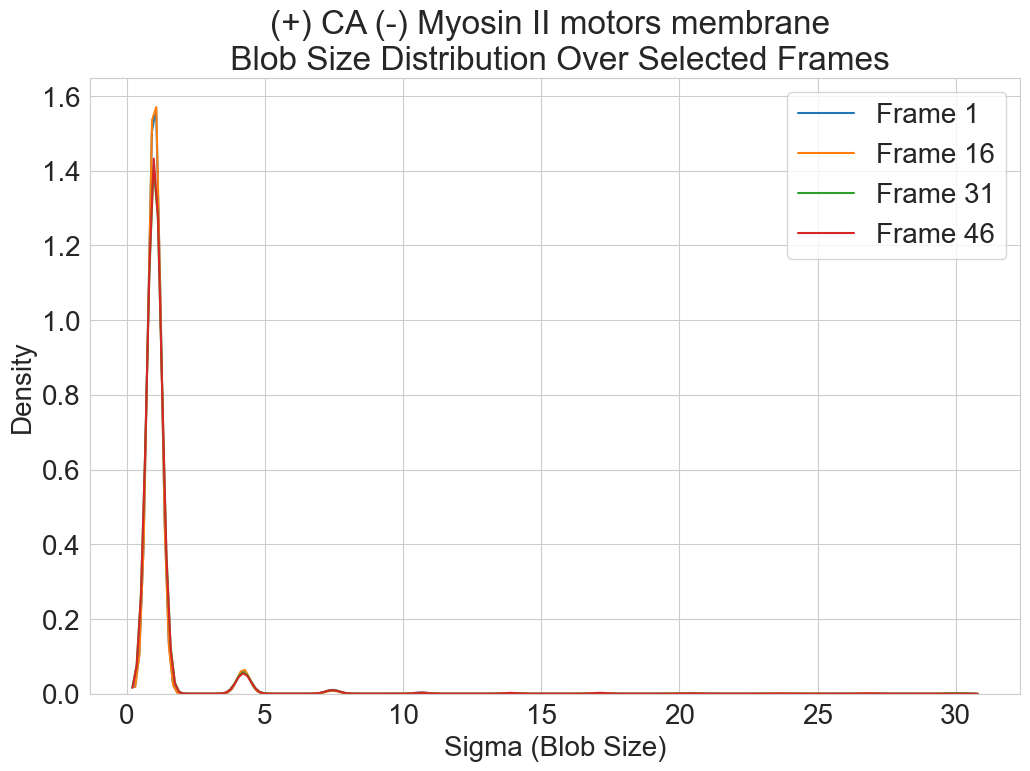

In [107]:
# Select frames to visualize distributions
selected_frames = np.linspace(1, num_frames, num=5, dtype=int)

plt.figure(figsize=(12, 8))
for frame in selected_frames:
    subset = df[df['frame'] == frame]
    sns.kdeplot(subset['sigma'], label=f'Frame {frame}')
plt.xlabel('Sigma (Blob Size)')
plt.ylabel('Density')
plt.title(f'{ex_data["name"]} {blob_type} \n Blob Size Distribution Over Selected Frames')
plt.legend()
plt.savefig(OUTPUT_PATH / Path(f'{movie}_{blob_type}_distribution.png'))
plt.show()


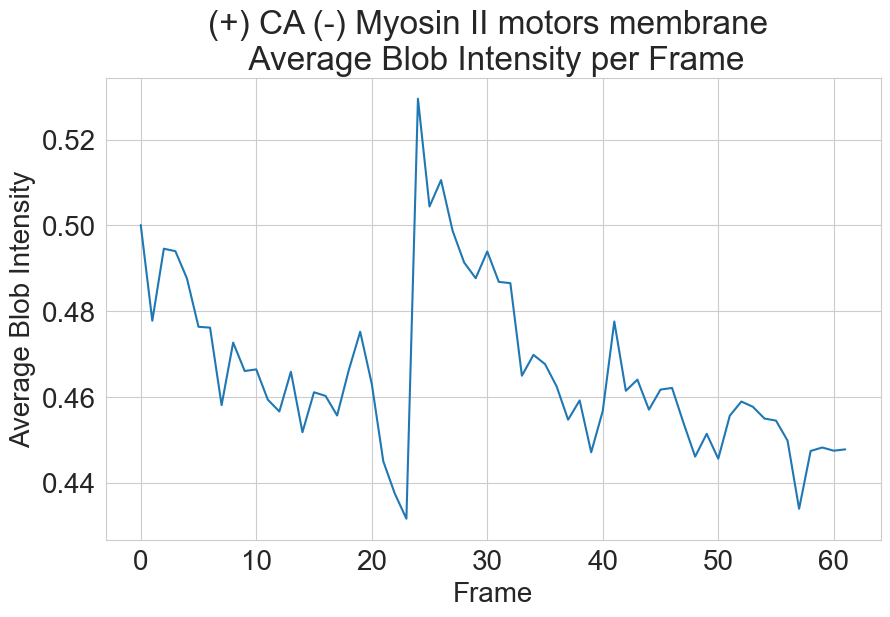

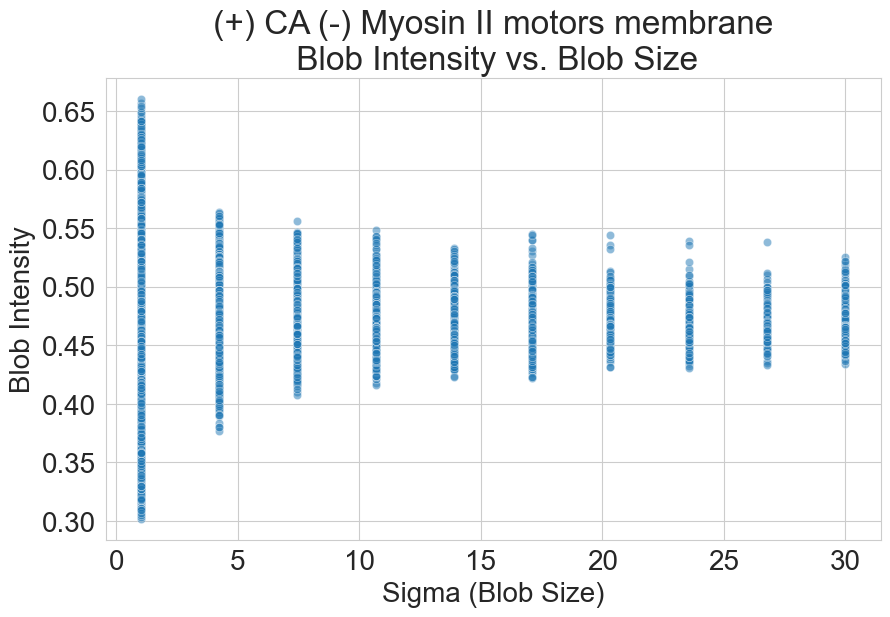

Correlation between blob size and intensity: 0.012


In [108]:
# Average intensity per frame
avg_intensity_per_frame = df.groupby('frame')['intensity'].mean()

plt.figure(figsize=(10, 6))
sns.lineplot(x=avg_intensity_per_frame.index, y=avg_intensity_per_frame.values)
plt.xlabel('Frame')
plt.ylabel('Average Blob Intensity')
plt.title(f'{ex_data["name"]} {blob_type} \n Average Blob Intensity per Frame')
plt.savefig(OUTPUT_PATH / Path(f'{movie}_{blob_type}_intensity_per_frame.png'))
plt.show()

# Correlation between blob size and intensity
plt.figure(figsize=(10, 6))
sns.scatterplot(x='sigma', y='intensity', data=df, alpha=0.5)
plt.xlabel('Sigma (Blob Size)')
plt.ylabel('Blob Intensity')
plt.title(f' {ex_data["name"]} {blob_type} \n Blob Intensity vs. Blob Size')
plt.savefig(OUTPUT_PATH / Path(f'{movie}_{blob_type}_intensity_vs_size.png'))
plt.show()

# Compute correlation coefficient
correlation = df['sigma'].corr(df['intensity'])
print(f"Correlation between blob size and intensity: {correlation:.3f}")


In [109]:
# tracks, please ignore for now
from scipy.spatial import cKDTree

# Initialize a dictionary to hold tracks
tracks = {}
current_track_id = 0

# Sort dataframe by frame
df_sorted = df.sort_values('frame')

# Parameters
max_distance = 20  # Maximum distance to consider the same blob across frames

# Iterate through frames
for frame in range(1, num_frames + 1):
    frame_blobs = df_sorted[df_sorted['frame'] == frame]
    if frame == 1:
        # Initialize tracks with first frame
        for idx, blob in frame_blobs.iterrows():
            tracks[current_track_id] = {'frames': [frame], 'y': [blob['y']], 'x': [blob['x']], 'sigma': [blob['sigma']]}
            df_sorted.at[idx, 'track_id'] = current_track_id
            current_track_id += 1
    else:
        # Get previous frame blobs with track IDs
        prev_frame = frame - 1
        prev_blobs = df_sorted[df_sorted['frame'] == prev_frame]
        prev_cords = prev_blobs[['y', 'x']].values
        prev_ids = prev_blobs['track_id'].values
        if len(prev_cords) == 0:
            # No previous blobs to track
            for idx, blob in frame_blobs.iterrows():
                tracks[current_track_id] = {'frames': [frame], 'y': [blob['y']], 'x': [blob['x']], 'sigma': [blob['sigma']]}
                df_sorted.at[idx, 'track_id'] = current_track_id
                current_track_id += 1
            continue
        # Build KD-tree for previous blobs
        tree = cKDTree(prev_cords)
        # Current frame blob coordinates
        current_coord = frame_blobs[['y', 'x']].values
        # Query nearest neighbors
        distances, indices = tree.query(current_coord, distance_upper_bound=max_distance)
        for i, (distance, index) in enumerate(zip(distances, indices)):
            if distance != np.inf:
                # Assign the track ID of the nearest previous blob
                track_id = prev_ids[index]
                tracks[track_id]['frames'].append(frame)
                tracks[track_id]['y'].append(current_coord[i][0])
                tracks[track_id]['x'].append(current_coord[i][1])
                tracks[track_id]['sigma'].append(frame_blobs.iloc[i]['sigma'])
                df_sorted.iloc[frame_blobs.index[i], df_sorted.columns.get_loc('track_id')] = track_id
            else:
                # Assign a new track ID
                tracks[current_track_id] = {'frames': [frame], 'y': [current_coord[i][0]], 'x': [current_coord[i][1]], 'sigma': [frame_blobs.iloc[i]['sigma']]}
                df_sorted.iloc[frame_blobs.index[i], df_sorted.columns.get_loc('track_id')] = current_track_id
                current_track_id += 1

# Display some tracks
for track_id, track in list(tracks.items())[:5]:
    print(f"Track {track_id}: Frames {track['frames']}, Positions {list(zip(track['y'], track['x']))}, Sigma {track['sigma']}")


Track 0: Frames [1, 2, 2, 3, 4, 5, 6, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 10, 10, 10, 11, 11, 12, 13, 13], Positions [(350.0, 141.0), (350.0, 138.0), (349.0, 143.0), (266.0, 307.0), (194.0, 164.0), (445.0, 183.0), (173.0, 401.0), (212.0, 7.0), (215.0, 5.0), (234.0, 18.0), (378.0, 368.0), (228.0, 19.0), (233.0, 20.0), (377.0, 365.0), (29.0, 294.0), (12.0, 48.0), (14.0, 44.0), (53.0, 89.0), (354.0, 446.0), (457.0, 74.0), (405.0, 210.0), (88.0, 115.0), (192.0, 141.0), (96.0, 274.0), (85.0, 467.0), (82.0, 468.0)], Sigma [1.0, 1.0, 1.0, 1.0, 1.0, 4.222222222222222, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Track 1: Frames [1, 2], Positions [(405.0, 191.0), (404.0, 190.0)], Sigma [1.0, 1.0]
Track 2: Frames [1, 2], Positions [(309.0, 112.0), (311.0, 113.0)], Sigma [1.0, 4.222222222222222]
Track 3: Frames [1], Positions [(87.0, 13.0)], Sigma [1.0]
Track 4: Frames [1], Positions [(113.0, 483.0)], Sigma [1.0]


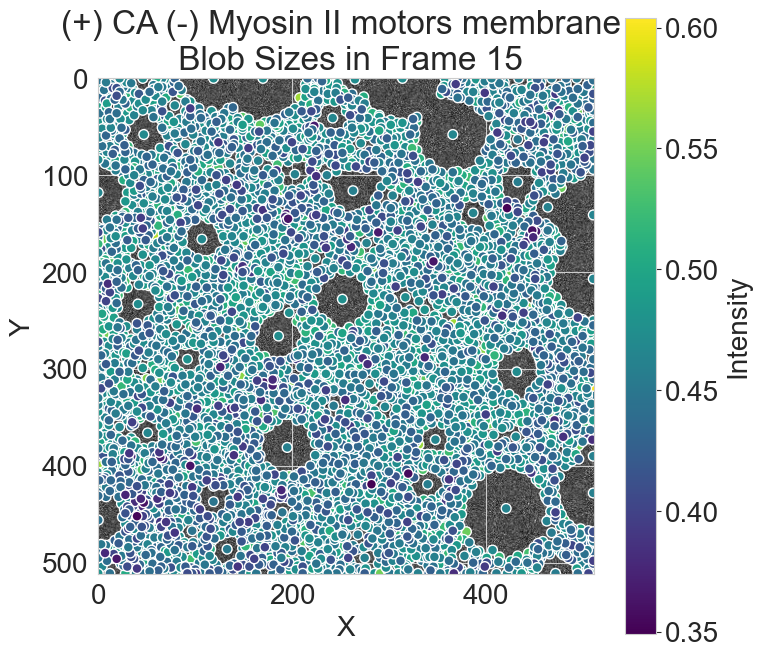

In [110]:
# blobs (peaks) image of surface/membrane with intensity
# Select a frame to visualize
selected_frame = 15  # For example, the last frame

# Load the selected image
image = image_sequence[selected_frame]
if image.ndim == 3:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = image / image.max()

# Get blobs for the selected frame
blobs = df[df['frame'] == selected_frame]

plt.figure(figsize=(8, 8))
plt.imshow(image, cmap='gray')
scatter = plt.scatter(blobs['x'], blobs['y'], c=blobs['intensity'], cmap='viridis', s=50, edgecolor='white')
plt.colorbar(scatter, label='Intensity')
plt.title(f'{ex_data["name"]} {blob_type} \n Blob Sizes in Frame {selected_frame}')
plt.xlabel('X')
plt.ylabel('Y')
plt.savefig(OUTPUT_PATH / Path(f'{movie}_{blob_type}_blob_frame{selected_frame}.png'))
plt.show()


Total number of frames loaded: 62


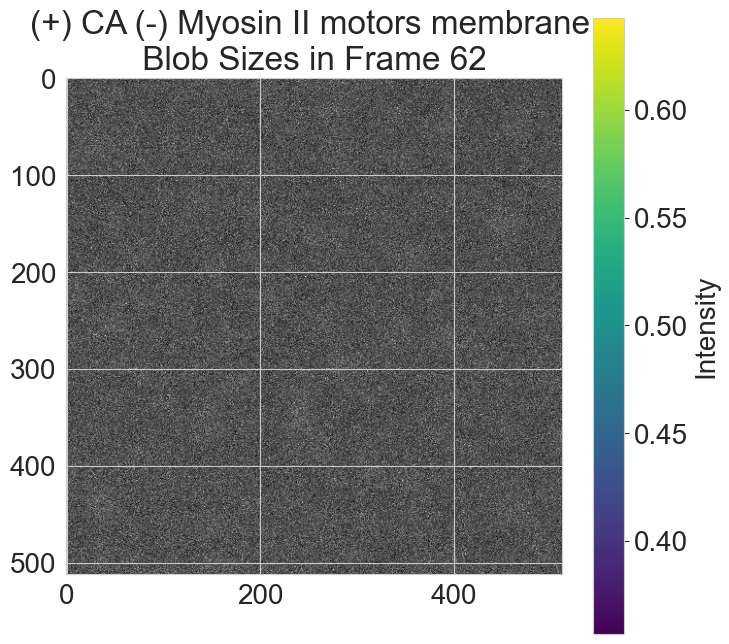

In [111]:
# code for creating animation of the surface,
# Anne, Shachar, please ignore, just look at the animation in the files attached...
import matplotlib.pyplot as plt

from matplotlib import animation
import numpy as np

# Total number of frames
num_frames = len(image_sequence)
print(f"Total number of frames loaded: {num_frames}")

# ----------------------------
# Step 2: Prepare the Plot
# ----------------------------

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Initialize the plot elements we want to animate
# Display the first image
initial_image = image_sequence[0]
img_display = ax.imshow(initial_image, cmap='gray', animated=True)

# Extract blobs for the first frame
selected_frame = 1  # Assuming frame indexing starts at 1
blobs = df[df['frame'] == selected_frame]

# Create the scatter plot for blobs
scatter = ax.scatter(blobs['x'], blobs['y'], c=blobs['intensity'], cmap='viridis', s=50, edgecolor='white', animated=True)

# Add a colorbar for sigma
cbar = plt.colorbar(scatter, ax=ax, label='Intensity')

# Set plot titles and labels
title = ax.set_title(f'{ex_data["name"]} {blob_type} \n Blob Sizes and Intensity in Frame {selected_frame}')
ax.set_xlabel('X')
ax.set_ylabel('Y')

# ----------------------------
# Step 3: Define the Animation Function
# ----------------------------

def animate(frame_num):
    """
    Update the image and scatter plot for the given frame number.
    """
    # Update the image
    ax.clear()

    img = image_sequence[frame_num]
    ax.imshow(img, cmap='gray')
    # Clear previous scatter

    # Get blobs for the current frame (assuming frame indexing starts at 1)
    current_frame = frame_num + 1
    blobs = df[df['frame'] == current_frame]

    # Update scatter plot with new blobs
    scatter = ax.scatter(blobs['x'], blobs['y'], c=blobs['sigma'], cmap='viridis', s=50, edgecolor='white')

    # Update title
    ax.set_title(f'{ex_data["name"]} {blob_type} \n Blob Sizes in Frame {current_frame} ')

    return img_display, scatter, title

# ----------------------------
# Step 4: Create the Animation
# ----------------------------

# Define the number of frames and interval
anim = animation.FuncAnimation(fig, animate, frames=num_frames, interval=200, blit=False)


# Replace 'coarsening_animation.gif' with your desired output path
anim.save(OUTPUT_PATH /  Path(f'{ex_data["name"]}_{blob_type}_animation.mp4'),  fps=5)

plt.show()


In [112]:
# returns x,y coordinates of a line passing through x0,y0 with angle alpha from the horizon. 
def get_line_scan(alpha, y0, x0):
    
    # calculate the slope
    m = np.tan(alpha)
    
    x = np.arange(512)
    # y = mx + c => c = y - mx
    c = y0 - m * x0
    y = (m * x + c).astype(int)
    y[y>511] = 511
    y[y<0] = 0
    return y

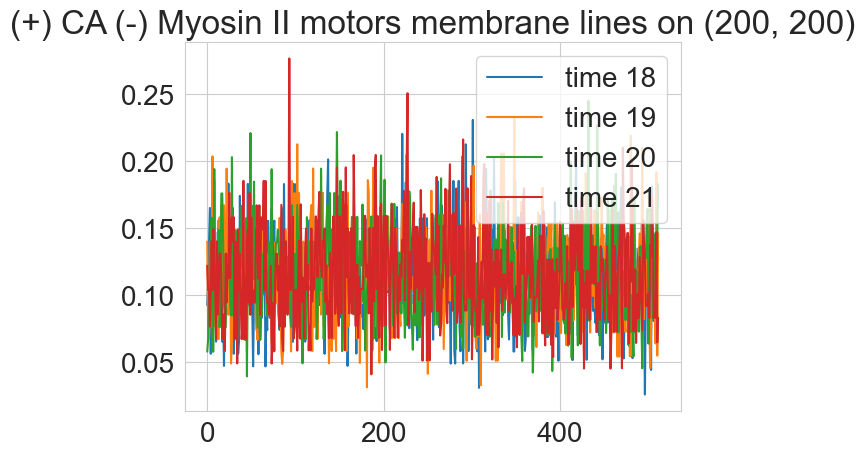

In [113]:
# plots surface(boundary) line scan over holes
y0, x0 =  200,200
for t  in range(18,22):
    for alpha in np.arange(0, np.pi, np.pi/4)[[0]]:
        plt.plot(image_sequence[t][get_line_scan(alpha,y0,x0)][x0], label = f'time {t}')
plt.legend(loc='upper right')
plt.title(f'{ex_data["name"]} {blob_type} lines on {y0,x0}')
plt.savefig(OUTPUT_PATH / Path(f'{movie}_{blob_type}_line_scan.png'))
plt.show()
    

In [4]:
surface = np.load(MOVIE_PATH / Path('np/height.npy'))
membrane = np.load(MOVIE_PATH / Path('np/membrane.npy'))
gel = np.load(MOVIE_PATH / Path('np/gel_norm.npy'))

In [ ]:
# plot gel cut in hole
y0, x0 =  200,200
width = 200
images = []
for t  in range(15,25):
    images.append(np.nanmax(gel[t,:, y0-width//2: y0 + width//2, x0-15:x0+15], axis = 2))

In [15]:
gaussian_images = [gaussian_filter(img,3) for img in images]

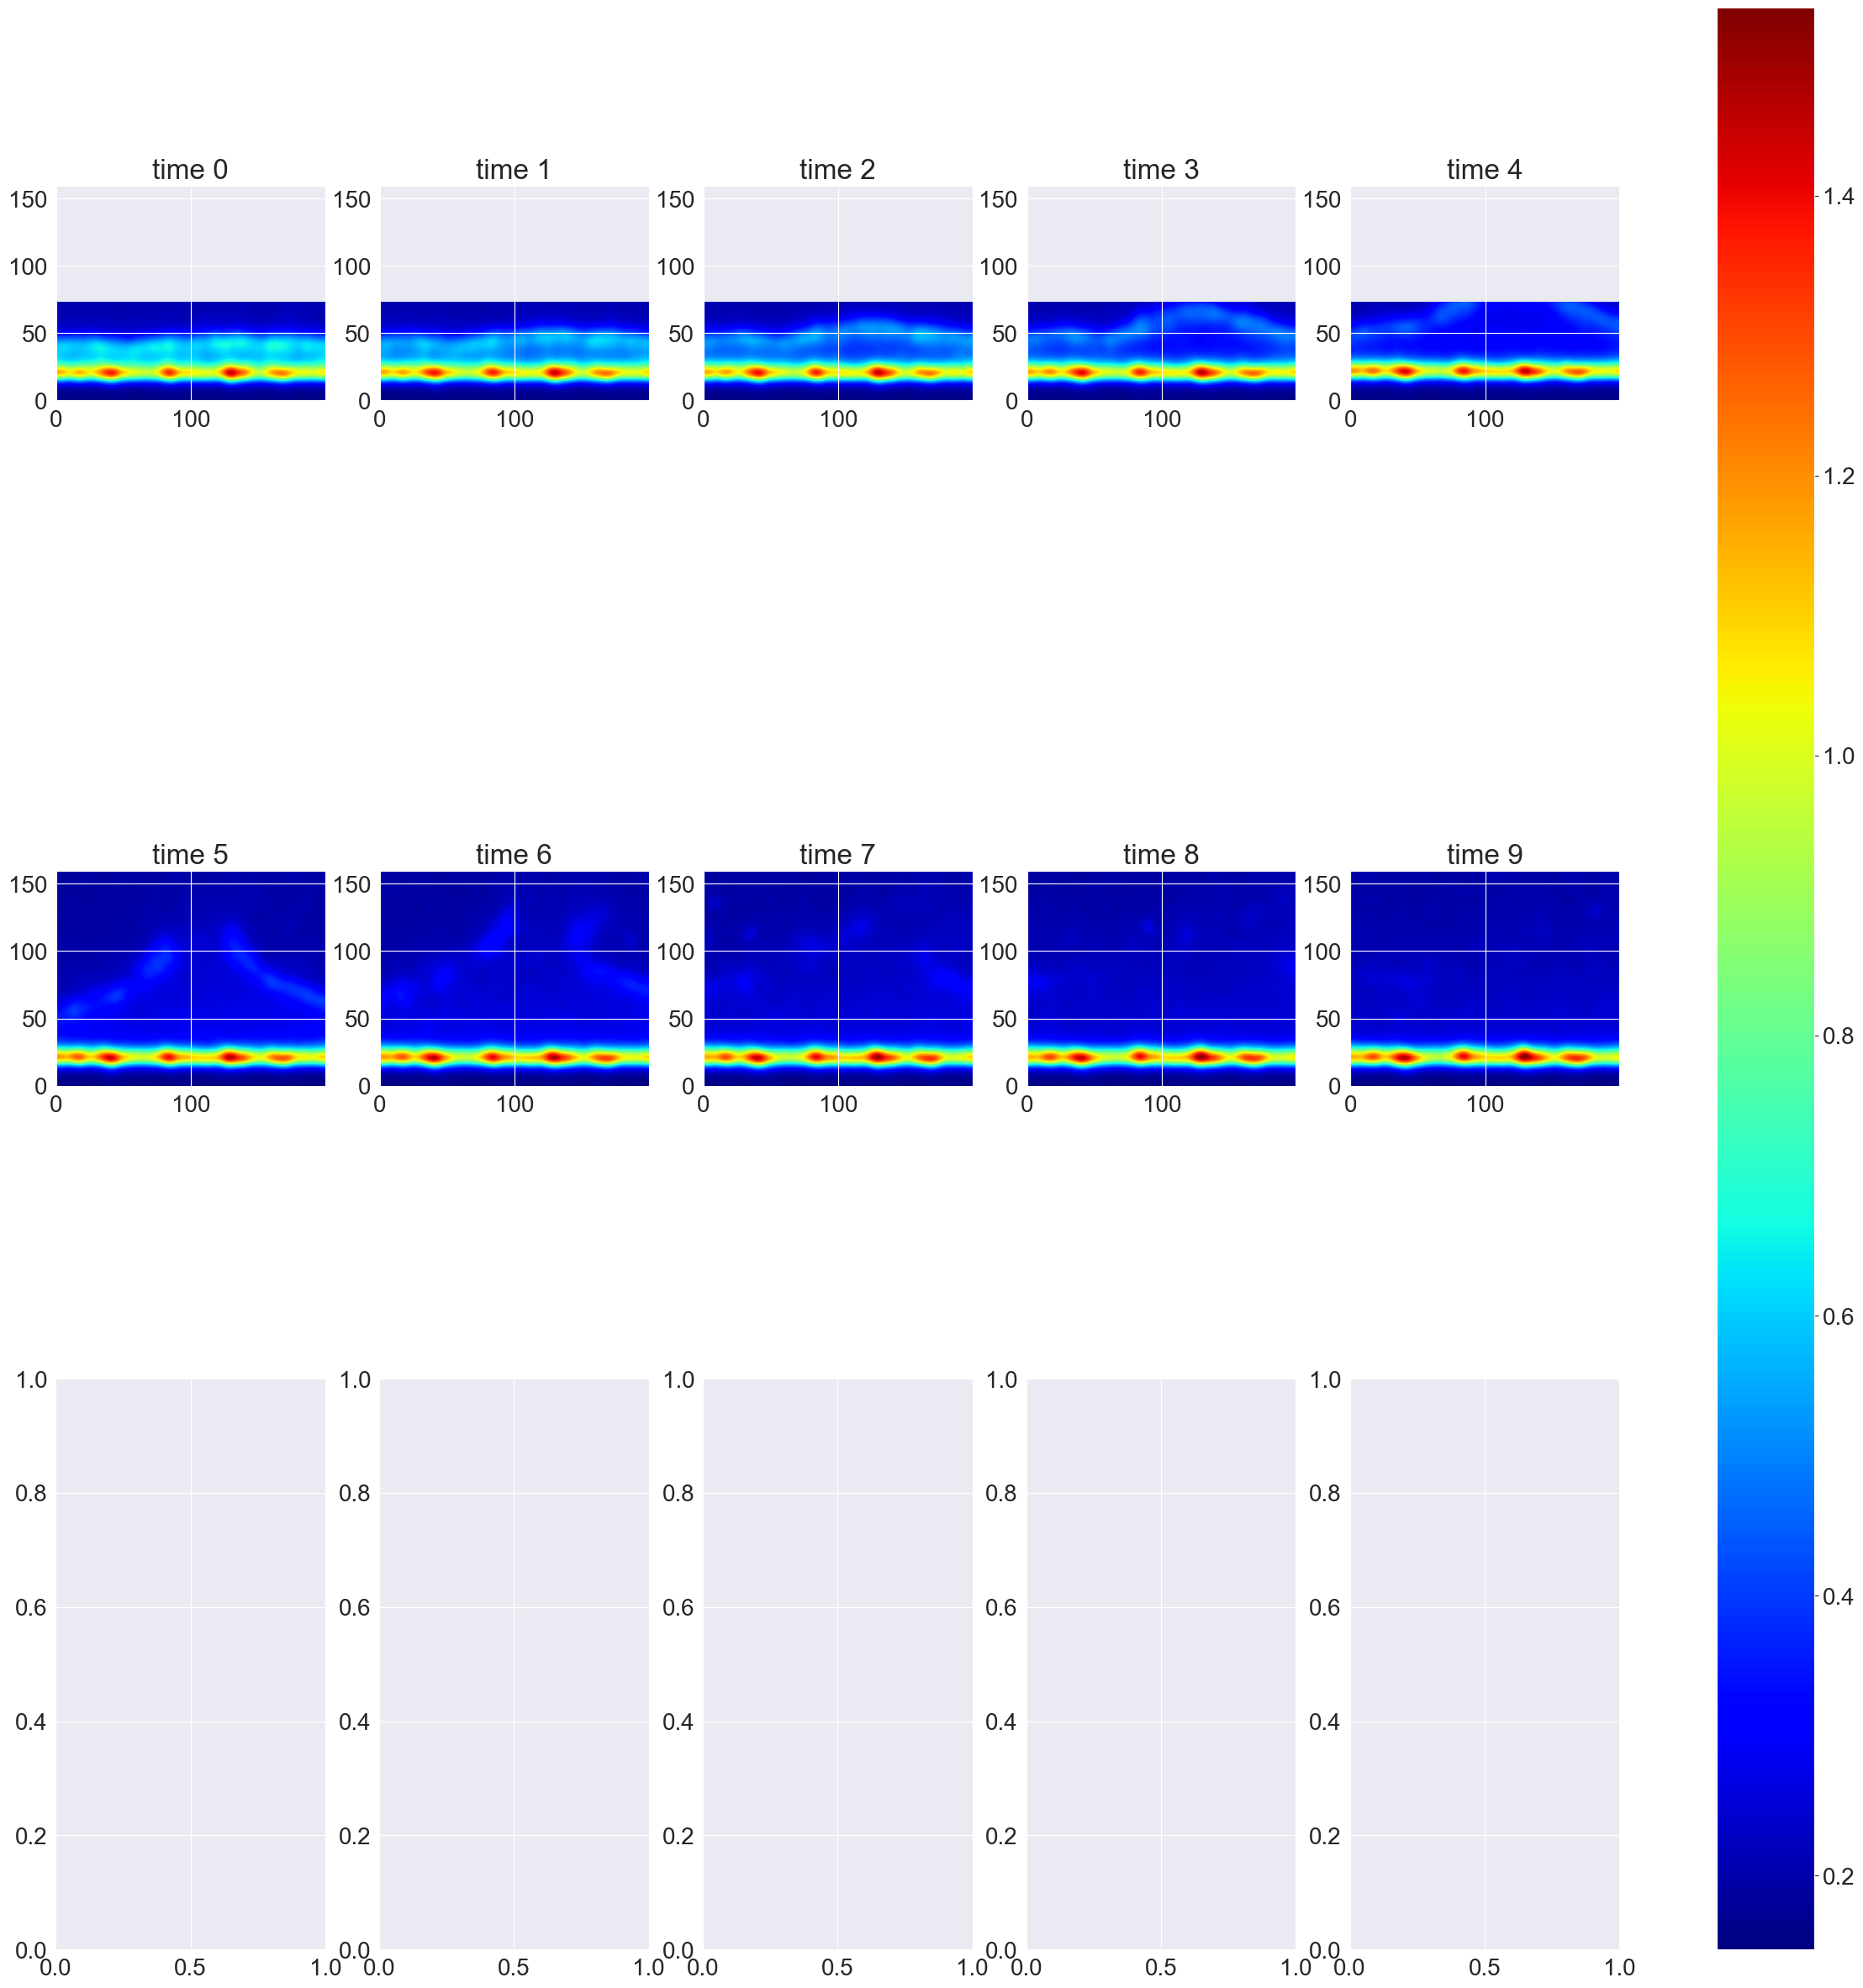

In [18]:
plt.rcParams['image.cmap'] = 'jet'

gu.show_imshow_sequence_with_colorbar(gaussian_images, time_points=range(len(images)))


In [219]:
from utils import analysis_utils as au
surface_i = au.get_surface_intensity(gel,surface)
print('surface')
membrane_i = au.get_membrane_intensity(gel,membrane)

surface


In [236]:
from numba import jit

@jit(nopython=True)
def corr(v1, v2):
    _mask = np.logical_and(~np.isnan(v1),  ~np.isnan(v2))
    if np.sum(_mask) == 0: return 0
    x=  v1[_mask] 
    y = v2[_mask]
    return np.corrcoef(x,y)[0,1]


In [135]:
times = [(t1, t2) for t1 in range(len(surface)) for t2 in range(len(membrane)) if t1 >= t2]

In [237]:
results = np.zeros((len(surface_i),len(membrane_i)))
v1= surface_i.reshape(len(surface_i),-1)
v2= membrane_i.reshape(len(membrane_i),-1)

In [238]:

for (t1, t2) in times:
    results[t1,t2] = corr(v1[t], v2[t])

In [204]:
corr(v1,v2)


-0.6038834210535463

In [203]:
v1, v2 = np.array([1,1,np.nan,3,10,10]), np.array([1,np.nan,6,50,-50,2])
#mask = np.logical_and(~np.isnan(v1),  ~np.isnan(v2))
#mask

In [183]:
~np.isnan(v1)

array([ True,  True, False,  True])

In [151]:
results[results < 0.9] = np.nan
    

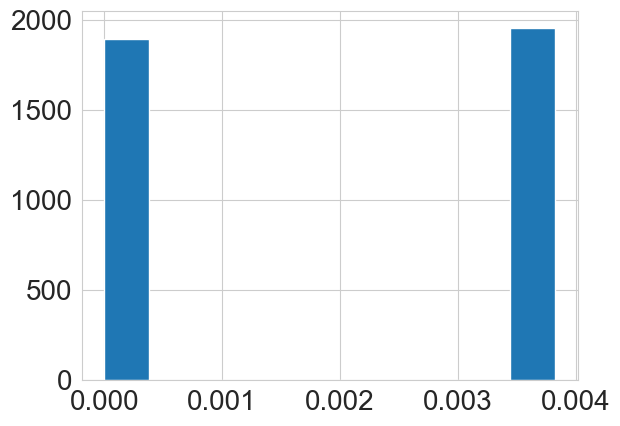

In [240]:
plt.hist(results.flatten())#, bins= np.linspace(0.02,0.023,50))
plt.show()

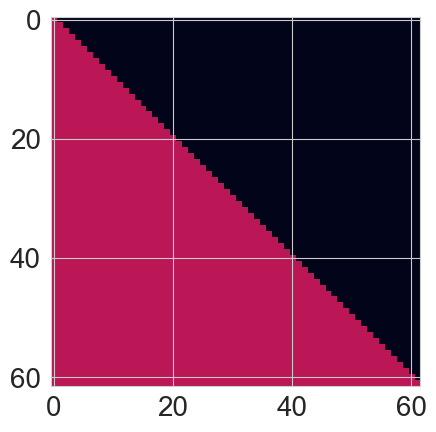

In [232]:
plt.imshow(results, vmin = 0.015 , vmax = 0.03)
plt.show()

In [245]:
d ={}
y0, x0 = 200,200
for track_id, track in list(tracks.items())[:5]:
    if 2 not in track['frames'] :
        continue
    print(f"Track {track_id}: Frames {track['frames']}, Positions {list(zip(track['y'], track['x']))}, Sigma {track['sigma']}")
    list(zip(track['y'], track['x']))
    d[str(track_id): np.nanmin(np.array([np.sqrt((x-x0)**2 + (y-y0)**2) for y,x in list(zip(track['y'], track['x']))]))]

Track 0: Frames [1, 2, 2, 3, 4, 5, 6, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 10, 10, 10, 11, 11, 12, 13, 13], Positions [(350.0, 141.0), (350.0, 138.0), (349.0, 143.0), (266.0, 307.0), (194.0, 164.0), (445.0, 183.0), (173.0, 401.0), (212.0, 7.0), (215.0, 5.0), (234.0, 18.0), (378.0, 368.0), (228.0, 19.0), (233.0, 20.0), (377.0, 365.0), (29.0, 294.0), (12.0, 48.0), (14.0, 44.0), (53.0, 89.0), (354.0, 446.0), (457.0, 74.0), (405.0, 210.0), (88.0, 115.0), (192.0, 141.0), (96.0, 274.0), (85.0, 467.0), (82.0, 468.0)], Sigma [1.0, 1.0, 1.0, 1.0, 1.0, 4.222222222222222, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


TypeError: unhashable type: 'slice'